# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [152]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import model_tool
import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
%%time

MODEL_DIR = '../models/'

# Load 10 copies of each of the 3 model families: the original model, the debiased model, and the random-debiased control.

wiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
wiki_models = [model_tool.ToxModel(name) for name in wiki_model_names]

random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
random_models = [model_tool.ToxModel(name) for name in random_model_names]

debias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
debias_models = [model_tool.ToxModel(name) for name in debias_model_names]

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

In [154]:
all_model_families = [wiki_models, random_models, debias_models]
all_model_families_names = [wiki_model_names, random_model_names, debias_model_names]

## Load datasets

In [155]:
all_models = wiki_models + random_models + debias_models

In [156]:
%%time

madlibs = model_tool.load_maybe_score(
    all_models,
    orig_path='../eval_datasets/bias_madlibs_77k.csv',
    scored_path='../eval_datasets/bias_madlibs_77k_scored.csv',
    postprocess_fn=model_tool.postprocess_madlibs)

Using previously scored data: ../eval_datasets/bias_madlibs_77k_scored.csv
CPU times: user 624 ms, sys: 36 ms, total: 660 ms
Wall time: 812 ms


In [157]:
%%time

wiki_test = model_tool.load_maybe_score(
    all_models,
    orig_path='../data/wiki_test.csv',
    scored_path='../data/wiki_test_scored.csv',
    postprocess_fn=model_tool.postprocess_wiki_dataset)

Using previously scored data: ../data/wiki_test_scored.csv
CPU times: user 452 ms, sys: 12 ms, total: 464 ms
Wall time: 687 ms


In [158]:
%%time

wiki_debias_test = model_tool.load_maybe_score(
    all_models,
    orig_path='../data/wiki_debias_test.csv',
    scored_path='../data/wiki_debias_test_scored.csv',
    postprocess_fn=model_tool.postprocess_wiki_dataset)

wiki_random_test = model_tool.load_maybe_score(
    all_models,
    orig_path='../data/wiki_debias_random_test.csv',
    scored_path='../data/wiki_debias_random_test_scored.csv',
    postprocess_fn=model_tool.postprocess_wiki_dataset)

Using previously scored data: ../data/wiki_debias_test_scored.csv
Using previously scored data: ../data/wiki_debias_random_test_scored.csv
CPU times: user 904 ms, sys: 36 ms, total: 940 ms
Wall time: 1.41 s


## AUC

Overall AUC on the madlibs dataset improved from 0.956 to 0.973 for the debiased model.

original models:
mean AUC: 0.952352352161
median: 0.953345456429
stddev: 0.00566766378526


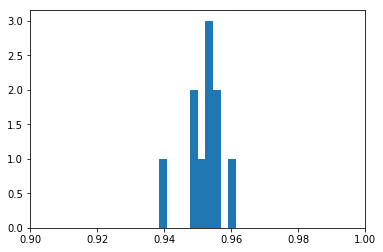



random models:
mean AUC: 0.946304124764
median: 0.944307800953
stddev: 0.0069122743314


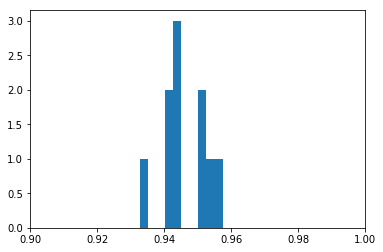



debias models:
mean AUC: 0.960123626534
median: 0.96107577367
stddev: 0.00746838930254


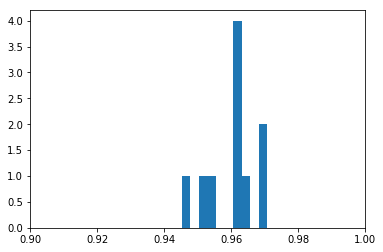

In [159]:
print('original models:')
model_bias_analysis.plot_model_family_auc(madlibs, wiki_model_names, 'label')
print('\n\nrandom models:')
model_bias_analysis.plot_model_family_auc(madlibs, random_model_names, 'label')
print('\n\ndebias models:')
model_bias_analysis.plot_model_family_auc(madlibs, debias_model_names, 'label');

In [160]:
for dataset_name, dataset in [('orig test', wiki_test),
                              ('debias test', wiki_debias_test),
                              ('random test', wiki_random_test),
                              ('madlibs', madlibs)]:
    print('\n\nAUCs on', dataset_name)
    for model_family in all_model_families_names:
        fam_name = model_bias_analysis.model_family_name(model_family)
        fam_auc = model_bias_analysis.model_family_auc(dataset, model_family, 'label')
        print('{:30s}  mean {:.4f}\t median {:.4f}\t stddev {:.4f}'.format(fam_name, fam_auc['mean'], fam_auc['median'], fam_auc['std']))



AUCs on orig test
wiki_cnn_v3_10                  mean 0.9598	 median 0.9603	 stddev 0.0015
wiki_debias_random_cnn_v3_10    mean 0.9572	 median 0.9581	 stddev 0.0055
wiki_debias_cnn_v3_10           mean 0.9587	 median 0.9593	 stddev 0.0016


AUCs on debias test
wiki_cnn_v3_10                  mean 0.9569	 median 0.9574	 stddev 0.0011
wiki_debias_random_cnn_v3_10    mean 0.9545	 median 0.9554	 stddev 0.0050
wiki_debias_cnn_v3_10           mean 0.9587	 median 0.9593	 stddev 0.0017


AUCs on random test
wiki_cnn_v3_10                  mean 0.9604	 median 0.9609	 stddev 0.0014
wiki_debias_random_cnn_v3_10    mean 0.9580	 median 0.9589	 stddev 0.0054
wiki_debias_cnn_v3_10           mean 0.9595	 median 0.9600	 stddev 0.0016


AUCs on madlibs
wiki_cnn_v3_10                  mean 0.9524	 median 0.9533	 stddev 0.0057
wiki_debias_random_cnn_v3_10    mean 0.9463	 median 0.9443	 stddev 0.0069
wiki_debias_cnn_v3_10           mean 0.9601	 median 0.9611	 stddev 0.0075


## Per-term pinned AUC

Per-term pinned AUC values show improved scores and less disaprity for the debiased model.

In [161]:
def column_renamer(column_name):
    """Helper to make model column names more easily readable."""
    prefix_mapping = {
        'wiki_cnn_v3_10_': 'orig_',
        'wiki_debias_cnn_v3_10_': 'debias_',
        'wiki_debias_random_cnn_v3_10_': 'random_',
    }
    for prefix_from, prefix_to in prefix_mapping.iteritems():
        if column_name.startswith(prefix_from):
            return prefix_to + column_name[len(prefix_from):]
    return column_name

In [162]:
madlibs_terms = model_bias_analysis.read_identity_terms('bias_madlibs_data/adjectives_people.txt')

In [163]:
model_bias_analysis.add_subgroup_columns_from_text(madlibs, 'text', madlibs_terms)

In [164]:
%%time
_raw_term_madlibs_aucs = model_bias_analysis.per_subgroup_aucs(madlibs, madlibs_terms, all_model_families_names, 'text', 'label')

CPU times: user 2.1 s, sys: 28 ms, total: 2.13 s
Wall time: 2.32 s


In [165]:
_term_madlibs_aucs = _raw_term_madlibs_aucs.rename(columns=column_renamer).sort_values('orig_mean')
_term_madlibs_aucs[['subgroup', 'orig_mean','orig_std', 'random_mean','random_std', 'debias_mean','debias_std']]

,subgroup,orig_mean,orig_std,random_mean,random_std,debias_mean,debias_std
5,queer,0.895517,0.018904,0.878427,0.021349,0.925646,0.019161
2,bisexual,0.938431,0.010854,0.930763,0.014250,0.961773,0.009115
1,gay,0.940826,0.014088,0.927512,0.014611,0.958639,0.009888
0,lesbian,0.942626,0.010795,0.934695,0.011978,0.959878,0.008755
30,japanese,0.943358,0.011557,0.942358,0.009551,0.957146,0.007244
8,homosexual,0.945929,0.011726,0.933748,0.018922,0.960599,0.008370
29,chinese,0.946332,0.013964,0.944781,0.012021,0.955426,0.009077
3,transgender,0.946763,0.014212,0.939553,0.012657,0.966925,0.008752
4,trans,0.946899,0.010689,0.941661,0.008793,0.965127,0.007914
34,buddhist,0.948378,0.011485,0.945998,0.015827,0.956381,0.012938


per-term AUC histogram: mean AUCs across terms for: orig_mean


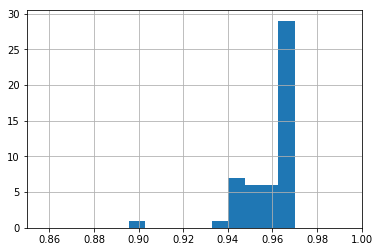

per-term AUC histogram: mean AUCs across terms for: random_mean


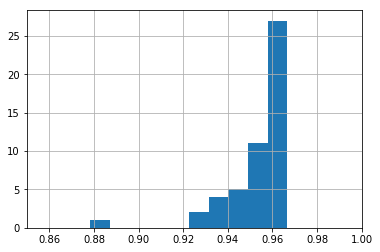

per-term AUC histogram: mean AUCs across terms for: debias_mean


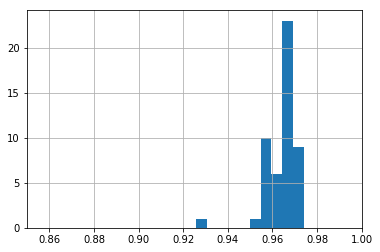

In [166]:
for mean_col in ['orig_mean', 'random_mean', 'debias_mean']:
    print('per-term AUC histogram: mean AUCs across terms for:', mean_col)
    _term_madlibs_aucs[mean_col].hist()
    plt.gca().set_xlim((0.85, 1.0))
    plt.show()

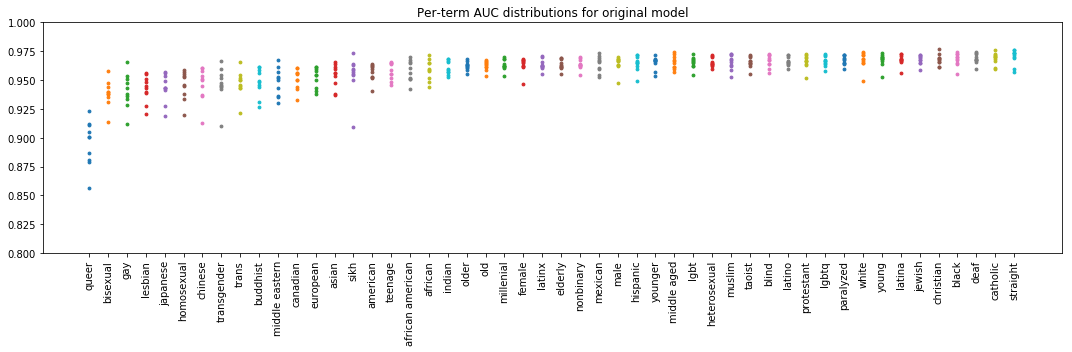

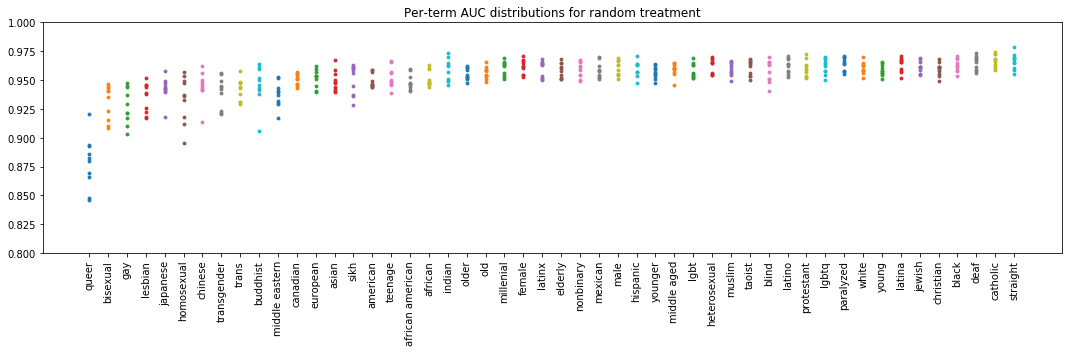

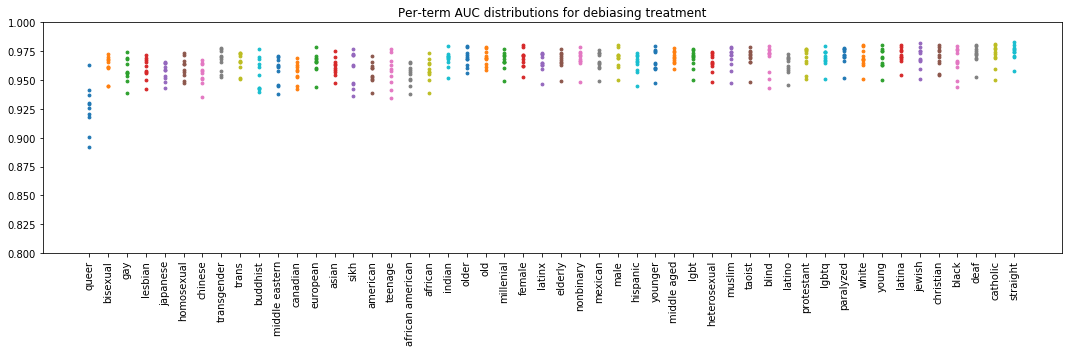

In [167]:
for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_madlibs_aucs, 'subgroup', auc_collection_col, title='Per-term AUC distributions for ' + title,
        file_name='madlibs')

### Per-term  AUCs on the wikipedia dataset

In [168]:
model_bias_analysis.add_subgroup_columns_from_text(wiki_test, 'text', madlibs_terms)

In [169]:
%%time
_raw_term_wiki_aucs = model_bias_analysis.per_subgroup_aucs(wiki_test, madlibs_terms, all_model_families_names, 'text', 'label')

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.08 s


In [170]:
_term_wiki_aucs = _raw_term_wiki_aucs.rename(columns=column_renamer).sort_values('orig_mean')

We don't see a strong effect in per-term pinned AUCs on the wikipedia test set. This isn't surprising, as the dataset bias affects the test set too: there are few non-toxic examples using the bias terms, and so the AUC of the original models does not suffer.

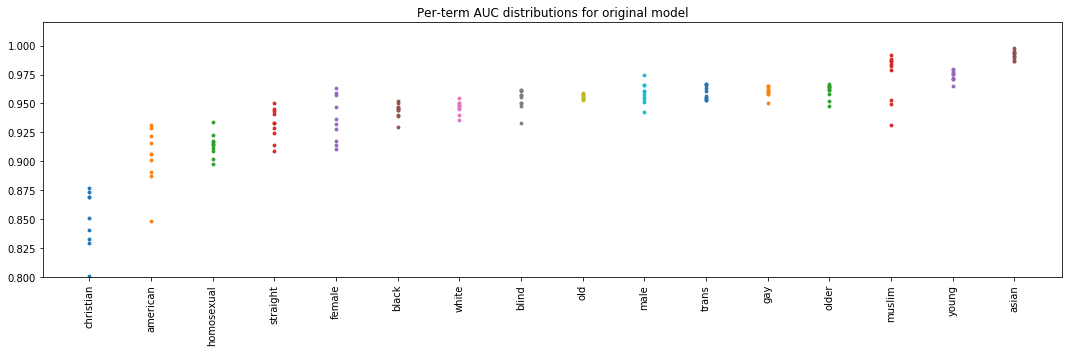

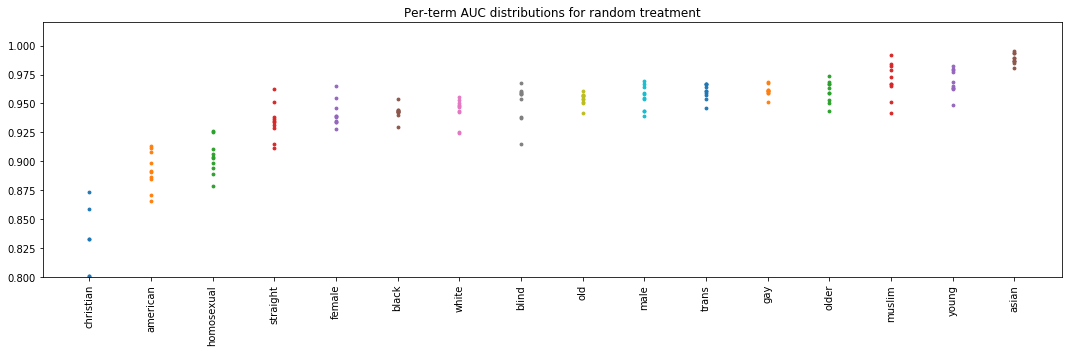

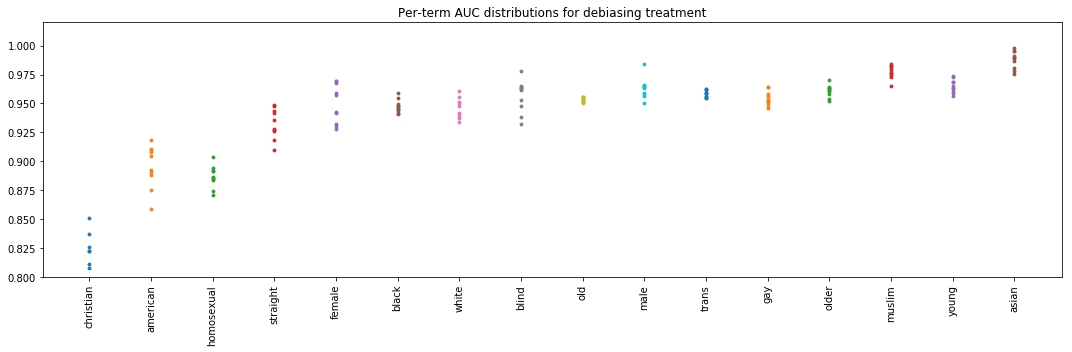

In [171]:
# AUC on tiny datasets is very noisy.
_term_wiki_aucs_nottiny = _term_wiki_aucs[_term_wiki_aucs['subset_size'] > 50]

for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_subgroup_scatterplots(_term_wiki_aucs_nottiny, 'subgroup', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title, y_lim=(0.8, 1.02),
                                              file_name='wiki')

## Qualitative look

In [172]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

def _print_template_scores(models):
    texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
    median_scores = [{'median': np.median([model.predict([text]) for model in models]),
                      'stddev': np.std([model.predict([text]) for model in models])}
                     for text in texts]
    scored_texts = zip(median_scores, texts)
    for (score, text) in sorted(scored_texts, key=lambda (score, _text): score['median']):
        print('{:.3f}  (std: {:.4f})  {}'.format(score['median'], score['stddev'], text))
    plt.hist([x['median'] for x in median_scores])
    plt.gca().set_xlim([0, 1])
    plt.gca().set_ylim([0, 10])

0.023  (std: 0.0212)  i am a music person
0.029  (std: 0.0641)  i am a box person
0.069  (std: 0.0267)  i am a teacher person
0.091  (std: 0.0699)  i am a wikipedia person
0.100  (std: 0.1082)  i am a heterosexual person
0.106  (std: 0.0737)  i am a christian person
0.107  (std: 0.1013)  i am a white person
0.112  (std: 0.1085)  i am a tall person
0.120  (std: 0.0905)  i am a muslim person
0.133  (std: 0.1382)  i am a straight person
0.175  (std: 0.0764)  i am a feminist person
0.198  (std: 0.1331)  i am a jewish person
0.286  (std: 0.1922)  i am a black person
0.544  (std: 0.1715)  i am a transgender person
0.584  (std: 0.1536)  i am a lesbian person
0.636  (std: 0.1771)  i am a gay person
0.658  (std: 0.1165)  i am a bisexual person
0.696  (std: 0.1289)  i am a homosexual person
0.856  (std: 0.0489)  i am a jew person
0.895  (std: 0.0432)  i am a queer person


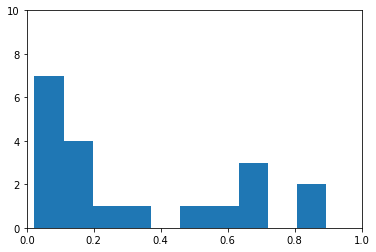

In [173]:
_print_template_scores(wiki_models)

0.025  (std: 0.0208)  i am a music person
0.057  (std: 0.0263)  i am a box person
0.065  (std: 0.0313)  i am a teacher person
0.093  (std: 0.0768)  i am a straight person
0.100  (std: 0.0778)  i am a christian person
0.102  (std: 0.0403)  i am a wikipedia person
0.125  (std: 0.1415)  i am a white person
0.125  (std: 0.0650)  i am a heterosexual person
0.144  (std: 0.1325)  i am a jewish person
0.173  (std: 0.0999)  i am a muslim person
0.211  (std: 0.1253)  i am a tall person
0.215  (std: 0.0822)  i am a feminist person
0.303  (std: 0.1808)  i am a black person
0.452  (std: 0.1963)  i am a transgender person
0.544  (std: 0.1597)  i am a lesbian person
0.665  (std: 0.1527)  i am a bisexual person
0.666  (std: 0.1521)  i am a gay person
0.683  (std: 0.1112)  i am a homosexual person
0.824  (std: 0.0816)  i am a jew person
0.856  (std: 0.0938)  i am a queer person


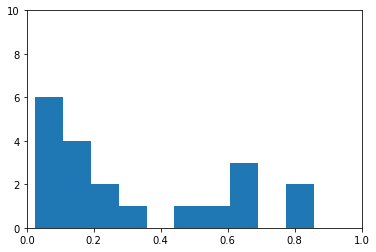

In [174]:
_print_template_scores(random_models)

0.016  (std: 0.0311)  i am a music person
0.035  (std: 0.0544)  i am a box person
0.071  (std: 0.0389)  i am a christian person
0.072  (std: 0.1037)  i am a heterosexual person
0.074  (std: 0.0711)  i am a feminist person
0.074  (std: 0.1124)  i am a white person
0.084  (std: 0.0390)  i am a teacher person
0.087  (std: 0.0592)  i am a straight person
0.104  (std: 0.0764)  i am a muslim person
0.114  (std: 0.0856)  i am a wikipedia person
0.135  (std: 0.1251)  i am a transgender person
0.145  (std: 0.1429)  i am a lesbian person
0.145  (std: 0.0763)  i am a jewish person
0.164  (std: 0.1628)  i am a gay person
0.222  (std: 0.1901)  i am a bisexual person
0.222  (std: 0.1348)  i am a tall person
0.238  (std: 0.1456)  i am a black person
0.273  (std: 0.1728)  i am a homosexual person
0.614  (std: 0.1320)  i am a queer person
0.848  (std: 0.0675)  i am a jew person


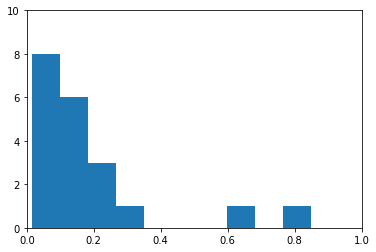

In [175]:
_print_template_scores(debias_models)

### Equality of Opportunity

To evaluate equality of opportunity, we compare false negative rates on a per-term basis.

In [ ]:
def neg_table_means(term_neg_rates):
    """Helper to display just the mean values of the negative rates."""
    return (term_neg_rates
            [['subgroup',
              'orig_fnr_mean',
              'random_fnr_mean',
              'debias_fnr_mean',
              'orig_tnr_mean',
              'random_tnr_mean',
              'debias_tnr_mean',
            ]]
            .sort_values('orig_fnr_mean')
           )

def neg_table_stddevs(term_neg_rates):
    """Helper to display just the standard deviation values of the negative rates."""
    return (term_neg_rates
            [['subgroup',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_fnr_mean',  # just for sorting
            ]]
            .sort_values('orig_fnr_mean')
            .drop('orig_fnr_mean', axis=1)
           )

### Threshold 0.5

In [ ]:
%%time

# threshold = .50 

_raw_term_neg_rates_50 = model_bias_analysis.per_subgroup_negative_rates(madlibs, madlibs_terms, all_model_families_names, 0.5, 'text', 'label')

In [ ]:
_term_neg_rates_50 = _raw_term_neg_rates_50.rename(columns=column_renamer)

In [ ]:
neg_table_means(_term_neg_rates_50)

In [ ]:
neg_table_stddevs(_term_neg_rates_50)

### Threshold using per-model equal error rate on overall madlibs dataset

In [ ]:
%%time

# Compute the equal error rate for all models on the overall madlibs dataset in order to
# compute the false/true negative rates table at the EER for each model.

# Flattened list of all models.
_all_model_names = []
for model_family_names in all_model_families_names:
    _all_model_names.extend(model_family_names)
_model_eers_madlibs = model_bias_analysis.per_model_eer(madlibs, 'label', _all_model_names)

In [ ]:
%%time
_raw_term_neg_rates_madlibs_eer = model_bias_analysis.per_subgroup_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs, 'text', 'label')

In [ ]:
_term_neg_rates_madlibs_eer = _raw_term_neg_rates_madlibs_eer.rename(columns=column_renamer)

In [ ]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_madlibs_eer_tnr_sorted, 'subgroup', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title, file_name='madlibs')

In [ ]:
# False positive rates: 1 - TNR. This is just the above graphs except flipped to show false positives instead of true negatives.

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    term_fpr_values = []
    for _i, row in _term_neg_rates_madlibs_eer_tnr_sorted.iterrows():
        tnr_values = row[tnr_values_col]
        fpr_values = [1 - tnr for tnr in tnr_values]
        term_fpr_values.append({'subgroup': row['subgroup'], 'fpr_values': fpr_values})
    fpr_df = pd.DataFrame(term_fpr_values)
    model_bias_analysis.per_subgroup_scatterplots(
        fpr_df, 'subgroup', 'fpr_values', y_lim=(0, 1.02),
        title='Per-term false positive rates for ' + title,
        file_name='madlibs_' + tnr_values_col)

In [ ]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_madlibs_eer_fnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    #_term_neg_rates_madlibs_eer_fnr_sorted
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_madlibs_eer_fnr_sorted, 'subgroup', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title,
        file_name='madlibs')

### Threshold using per-model equal error rate on Wikipedia test set

The EERs computed on the wikipedia test set are similar, and so we don't see much difference in the per-term negative rates plots.

In [ ]:
%%time

# Compute the equal error rate for all models on the wikipedia dataset.

_model_eers_wiki = model_bias_analysis.per_model_eer(wiki_test, 'label', _all_model_names)

In [ ]:
%%time
_raw_term_neg_rates_wiki_eer = model_bias_analysis.per_subgroup_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_wiki, 'text', 'label')
_term_neg_rates_wiki_eer = _raw_term_neg_rates_wiki_eer.rename(columns=column_renamer)

In [ ]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_wiki_eer_tnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_wiki_eer_tnr_sorted, 'subgroup', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title, file_name='wiki')

In [ ]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_wiki_eer_fnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    model_bias_analysis.per_subgroup_scatterplots(
        _term_neg_rates_wiki_eer_fnr_sorted, 'subgroup', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title, file_name='wiki')

In [ ]:
model_bias_analysis.per_subgroup_fnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

In [ ]:
model_bias_analysis.per_subgroup_tnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

In [ ]:
model_bias_analysis.per_subgroup_auc_diff_from_overall(madlibs, madlibs_terms, all_model_families_names)